In [4]:
%pip install -r requirements.txt

You should consider upgrading via the '/home/rsiddique/.pyenv/versions/3.9.8/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import inv
f = open('tester_log_metdata.json')
metadata = json.load(f)
f2 = open('tester_log_pathdata.json')
pathdata = json.load(f2)

alldata = pathdata
for key in metadata:
    alldata[key] = metadata[key]

In [6]:
print(alldata['garAnchors'][-1][0].keys())
print(alldata['savedRouteGeospatialLocations'][0].keys())

lat_long = np.array(list(map(lambda x: (x['GARAnchorUUID'], x['longitude'], x['latitude'], x['geoAnchorTransform']), alldata['savedRouteGeospatialLocations'])))
lat_long_only = np.array(list(map(lambda x: (x[1],x[2]), lat_long)))
lat_long_poses = np.array(list(map(lambda x: (x[-1]), lat_long)))
gar_anchors = np.array(list(map(lambda x: (x['identifier'], x['transform']), alldata['garAnchors'][-1])))

# filter and sort gar_anchors to match corresponding ID for lat_long points
gar_anchors_filtered = []
for x in lat_long:
  for y in gar_anchors:
    if x[0] == y[0]:  # if IDs match
      gar_anchors_filtered.append(y)
print(gar_anchors_filtered[0][-1])
gar_anchors_poses_filtered = np.array(list(map(lambda x: (x[-1]), gar_anchors_filtered)))
df = pd.DataFrame(lat_long, columns=['ID','lon', 'lat', 'pose'])
df.keys()
print(len(gar_anchors_poses_filtered))
print(len(lat_long_poses))

dict_keys(['identifier', 'cloudIdentifier', 'hasValidTransform', 'transform'])
dict_keys(['GARAnchorUUID', 'altitude', 'geoAnchorTransform', 'altitudeUncertainty', 'latitude', 'horizontalUncertainty', 'heading', 'longitude', 'headingUncertainty'])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (66, 4) + inhomogeneous part.

[-71.26406787  42.29330984]
[[18.88207693 41.69474501]
 [32.06094632 41.60258985]
 [35.41955458 41.60261009]
 [19.06522225 41.60246656]
 [21.1975719  41.63342331]]


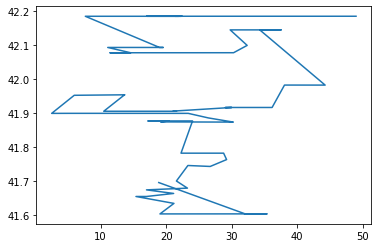

In [ ]:
lat_long_poses_reshaped = np.array(list(map(lambda x: np.array(x).reshape(4,4).T, lat_long_poses)))
gar_anchors_poses_filtered_reshaped = np.array(list(map(lambda x: np.array(x).reshape(4,4).T, gar_anchors_poses_filtered)))
# pose_difference = inv(query_pose) @ train_pose
pose_difference = np.array(list(map(lambda x: inv(x[0]) @ x[1], zip(lat_long_poses_reshaped, gar_anchors_poses_filtered_reshaped))))
lat_long_only_reshaped = np.hstack(
            (lat_long_only, np.ones((lat_long_only.shape[0], 2)))
        ).T
# print(lat_long_only_reshaped.T[0].shape)
# print(inv(pose_difference[0]).shape)
transformed_lat_long = np.array(list(map(lambda x: inv(x[0]) @ x[1].T, zip(pose_difference, lat_long_only_reshaped.T))))
new_lat_long = np.array(list(map(lambda x: (x[0], x[1]), transformed_lat_long)))
print(lat_long_only[0])
print(new_lat_long[0:5])
new_df = pd.DataFrame(new_lat_long, columns=['lon', 'lat'])
new_df_x = np.array([x[0] for x in new_lat_long])
new_df_y = np.array([x[1] for x in new_lat_long])
plt.plot(new_df_x, new_df_y)

In [ ]:
# your code here
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import pydeck as pdk
import pandas as pd

# bounding box for area
bbox = [-71.263053,42.289025,-71.257710,42.292009]

# query for all satellite_dishes in the area
overpass = Overpass()
query = overpassQueryBuilder(bbox=bbox, elementType='node', selector='"man_made"="satellite_dish"', out='body')
result = overpass.query(query)

# convert result data to JSON
JSON = result.toJSON()  
satellite_dishes = JSON['elements']

# create viewState and set paratmeters to lat and long near Sweden
view_state = pdk.ViewState(
    latitude=42.293390,
    longitude=-71.263974,
    zoom=19,
    max_zoom=20,
    pitch=40.5,
    bearing=-27.36
)

# create pydeck layer for the satellite_dishes
layer = pdk.Layer(
    'ScatterplotLayer',
    data=df,
    get_position='[lon, lat]',
    get_radius=0.2,
    get_fill_color=[255, 140, 0],
    pickable=True
)
# create pydeck layer for the city locations
layer_2 = pdk.Layer(
    'ScatterplotLayer',
    data=new_df,
    get_position='[lon, lat]',
    get_radius=0.2,
    get_fill_color=[0, 255, 0],
    pickable=True
)

# create pydeck map
r = pdk.Deck(layers=[layer, layer_2], initial_view_state=view_state, tooltip={"text": "coords"})
r.to_html('locations.html')


